In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math , numpy as np
import scipy.stats as stats
import pm4py

In [2]:
#---------------------------------------------------
#
# Config *** TO UPDATE ***
#
#---------------------------------------------------
EYE_IMOTIONSFEATURES_AND_AOIS_FILE = "out/eventsDataWithAois.csv" 
QUESTION_FILE_PARSED = "QuestionSetParsed.csv"
PERCEIVED_DIFFICULTY_DATA = "out/perceivedDifficulty.csv" 
SUBPROCESSES_INFO_FILE = "subprocesses.csv"
EYEMIND_FULL_DATA = "out/allDataEyeMind.csv" 
DEMOGRAPHIC_FILE = "data/demographics.csv"
TASKS_PER_PARTICIPANTS_TO_EXCLUDE_FILE = "data/TaskToExcludeFailedAmbiguityIdentification.csv"
AMBIGUITY_ELEMENTS_DETAILS = "ambiguityElements.csv"
MODELS_PATH = "material"

In [3]:
diffMappingToScore = {'Easy':0, 'Rather easy':1, 'Neutral':2, 'Rather difficult':3, 'Difficult':4}

In [4]:
def mappingOtherQuestionsToMainQuestion(arr,mod):

    # Filter array to keep only elements divisible by mod
    filtered_arr = [x for x in arr if x % mod == 0]

    # Create dictionary with key = element and value = element-mod-1
    result_dict = {x: x-(mod-1) for x in filtered_arr}

    return result_dict

In [5]:
def compute_descriptives_mean(df, filter_col, filter_val, group_cols, group_cols_not_for_overall_mean, measure_col):
 
    # Filter dataframe
    filtered_df = df[df[filter_col] == filter_val]
    
    # Group by group_cols and calculate the mean for each measure
    grouped_means = filtered_df.groupby(group_cols+group_cols_not_for_overall_mean)[[measure_col]].mean().reset_index()
    

    # Drop participant and question columns from group columns and compute the mean
    overall_mean = grouped_means.groupby(group_cols,as_index=False)[[measure_col]].mean()

    return overall_mean.round(3)

In [6]:
def compute_inferentials(data, group_cols, measure_col, sub_col, conditions, additional_filters=None):

    # Apply additional filters if provided
    if additional_filters:
        for key, value in additional_filters.items():
            data = data[data[key] == value]
            
    # Group by group_cols and calculate the mean
    data = data.groupby(group_cols,as_index=False).agg({measure_col:'mean'})
    
    #regroup by the first n elements of the group_calls and compute mean
    data = data.groupby(group_cols[:2],as_index=False).agg({measure_col:'mean'})
    
    
    for cat1, cat2 in conditions:
        
        print(cat1,cat2)

        data_cat1 = data.loc[(data[sub_col]==cat1)][group_cols[:1]+[measure_col]].dropna()
        data_cat2 = data.loc[(data[sub_col]==cat2)][group_cols[:1]+[measure_col]].dropna()
        

        merged = data_cat1.merge(data_cat2, on=group_cols[:1], suffixes=('_cat1', '_cat2'), how='inner')
         
        
        print(stats.wilcoxon(merged[f'{measure}_cat1'], merged[f'{measure}_cat2']))

In [7]:
def compute_descriptives_meanFixationCount(df, filter_col, filter_val, group_cols, group_cols_not_for_overall_mean, measure_col,measure_out):
 
    # Filter dataframe
    filtered_df = df[df[filter_col] == filter_val]
    
    # Group by group_cols and calculate the mean for each measure
    grouped_means = filtered_df.groupby(group_cols+group_cols_not_for_overall_mean)[[measure_col]].count().reset_index()
    
    # Drop participant and question columns from group columns and compute the mean
    overall_mean = grouped_means.groupby(group_cols,as_index=False)[[measure_col]].mean()
    
     #rename to match the expected colunsn names of what coming afterwards
    overall_mean = overall_mean.rename(columns={
     measure_col: measure_out
    })

    return overall_mean.round(3)

In [8]:
def compute_inferentials_meanFixationCount(data, group_cols, measure_col, sub_col, conditions, additional_filters=None):
    
    # Apply additional filters if provided
    if additional_filters:
        for key, value in additional_filters.items():
            data = data[data[key] == value]
            
    # Group by group_cols and calculate the count
    data = data.groupby(group_cols,as_index=False).agg({measure_col:'count'})
    
    #regroup by the first n elements of the group_calls and compute mean
    data = data.groupby(group_cols[:2],as_index=False).agg({measure_col:'mean'})
    
    for cat1, cat2 in conditions:
        
        print(cat1,cat2)

        data_cat1 = data.loc[(data[sub_col]==cat1)][group_cols[:1]+[measure_col]].dropna()
            
        data_cat2 = data.loc[(data[sub_col]==cat2)][group_cols[:1]+[measure_col]].dropna()
        
        
        merged = data_cat1.merge(data_cat2, on=group_cols[:1], suffixes=('_cat1', '_cat2'), how='inner')
        
        print(stats.wilcoxon(merged[f'{measure}_cat1'], merged[f'{measure}_cat2']))

In [9]:
def compute_descriptives_AOIRunCount(df, group_cols, group_cols_not_for_overall_mean, measure_col):
 
    # Group by group_cols and calculate the mean for each measure
    grouped_means = df.groupby(group_cols+group_cols_not_for_overall_mean)[[measure_col]].count().reset_index()
    
    # Drop participant and question columns from group columns and compute the mean
    overall_mean = grouped_means.groupby(group_cols,as_index=False)[[measure_col]].mean()

    return overall_mean.round(3)

In [10]:
def compute_inferentials_AOIRunCount(data, group_cols, measure_col, sub_col, conditions, additional_filters=None):
    # Apply additional filters if provided
    if additional_filters:
        for key, value in additional_filters.items():
            data = data[data[key] == value]

    # Group by group_cols and calculate the count
    data = data.groupby(group_cols,as_index=False).agg({measure_col:'count'})

    #regroup by the first n elements of the group_calls and compute mean
    data = data.groupby(group_cols[:2],as_index=False).agg({measure_col:'mean'})
    

    for cat1, cat2 in conditions:

        print(cat1,cat2)

        data_cat1 = data.loc[(data[sub_col]==cat1)][group_cols[:1]+[measure_col]].dropna()
        data_cat2 = data.loc[(data[sub_col]==cat2)][group_cols[:1]+[measure_col]].dropna()
        

        merged = data_cat1.merge(data_cat2, on=group_cols[:1], suffixes=('_cat1', '_cat2'), how='inner')

        print(stats.wilcoxon(merged[f'{measure}_cat1'], merged[f'{measure}_cat2']))

In [11]:
def isAmbigiousSubProcess(val):
    if val=="sub1" or val=="sub3":  return 0;
    elif val=="sub2": return 1;
    else: return np.nan;

In [12]:
def identifyTransition(data,rowIndex):
	# check that the last row is not reached yet
	if rowIndex<data.shape[0]-1:
		# check that the participant, task and tabName are the same
		if data.iloc[rowIndex]['participant']==data.iloc[rowIndex+1]['participant'] and data.iloc[rowIndex]['currentQuestion']==data.iloc[rowIndex+1]['currentQuestion']  and data.iloc[rowIndex]['tabName']==data.iloc[rowIndex+1]['tabName']:
			return pd.Series([data.iloc[rowIndex]['participant'],data.iloc[rowIndex]['currentQuestion'],data.iloc[rowIndex]['Type1'],data.iloc[rowIndex]['tabName'],data.iloc[rowIndex]['ambigiousSubProcess'],data.iloc[rowIndex]['SubID'],data.iloc[rowIndex]['element'],data.iloc[rowIndex]['element_type'], data.iloc[rowIndex+1]['element'],data.iloc[rowIndex+1]['element_type']]) 
	return pd.Series([np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]) 

In [13]:
def get_context(subID):
    if(subID=="sub1"): return "ModelBefore"
    elif(subID=="sub3"): return "ModelAhead"
    elif(subID=="sub2"): return "Same Model"
    else: return ""

In [14]:
def dfg(f_eifaData_gr,task,sub,participant,plot=0):
    
    subset = f_eifaData_gr[(f_eifaData_gr["Type4"]==task) & (f_eifaData_gr["participant"]==participant) ] 
        
    subset["timestamp_formatted"] = pd.to_datetime(subset['Timestamp'], unit='ms')

    # Filter the dataframe to keep only activities
    subset = subset[(subset['element_type']=="task") & (subset['SubID']==sub)]
    
    #if there is no data, skip
    if len(subset)==0:
        return

    # Generate process maps if there is data
    subset = pm4py.format_dataframe(subset, case_id='caiseID', activity_key='name', timestamp_key='timestamp_formatted')
    log = pm4py.convert_to_event_log(subset)
    pm4py.write_xes(log, "out/eventLogs/log_"+task+".xes", case_id_key='case:concept:name')
    dfg, start_activities, end_activities = pm4py.discover_dfg(log)
    if plot==1:
        pm4py.view_dfg(dfg, start_activities, end_activities)
    pm4py.save_vis_dfg(dfg, start_activities, end_activities, 'processMaps/'+task+'_'+('non-ambigious-subProcess' if sub=="sub1" else 'ambigious-subProcess')+'_'+participant+'.png')

In [15]:
#---------------------------------------------------
# Read EYE_IMOTIONSFEATURES_AND_AOIS_FILE
eifaData = pd.read_csv(EYE_IMOTIONSFEATURES_AND_AOIS_FILE) #EIFA stands for eifa
#---------------------------------------------------

#---------------------------------------------------
# Read PERCEIVED_DIFFICULTY_DATA
perceivedDifficultyData = pd.read_csv(PERCEIVED_DIFFICULTY_DATA) 
#---------------------------------------------------

#---------------------------------------------------
# Read QUESTION_FILE_PARSED
questionsFileParsed = pd.read_csv(QUESTION_FILE_PARSED)
#---------------------------------------------------

#---------------------------------------------------
# Read SUBPROCESSES_INFO_FILE
subProcessesInfo = pd.read_csv(SUBPROCESSES_INFO_FILE)
#---------------------------------------------------

#---------------------------------------------------
# Read EYEMIND_DATA
eyeMindFullData = pd.read_csv(EYEMIND_FULL_DATA) 
#---------------------------------------------------

#---------------------------------------------------
# Read DEMOGRAPHIC_FILE 
demographicsData = pd.read_csv(DEMOGRAPHIC_FILE)
#---------------------------------------------------

#---------------------------------------------------
# Read TASKS_PER_PARTICIPANTS_TO_EXCLUDE_FILE 
tasksPerParticipantsToExclude = pd.read_csv(TASKS_PER_PARTICIPANTS_TO_EXCLUDE_FILE)
#---------------------------------------------------

#---------------------------------------------------
# Read AMBIGUITY_ELEMENTS_DETAILS 
ambiguityElementsDetails = pd.read_csv(AMBIGUITY_ELEMENTS_DETAILS)
#---------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [16]:
##### Add additional question attributes to eifaData, pupiFiltered and perceived difficulty data ###

In [17]:
eifaData = eifaData.merge(questionsFileParsed, left_on='currentQuestion', right_on='id', how='left')

In [18]:
eifaData.columns

Index(['participant', 'FixID', 'Fixation X', 'Fixation Y', 'Fixation Start',
       'Fixation End', 'Fixation Duration', 'Fixation Dispersion', 'SacID',
       'Saccade Start', 'Saccade End', 'Saccade Duration', 'Saccade Amplitude',
       'Saccade Peak Velocity', 'Saccade Peak Acceleration',
       'Saccade Peak Deceleration', 'Saccade Direction', 'currentQuestion',
       'tabName_element', 'Timestamp', 'tabName', 'element',
       'iMotionsTimestampStart', 'iMotionsTimestampEnd', 'Anger', 'Contempt',
       'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Engagement',
       'Valence', 'Sentimentality', 'Confusion', 'Neutral', 'Attention',
       'Brow Furrow', 'Brow Raise', 'Cheek Raise', 'Chin Raise', 'Dimpler',
       'Eye Closure', 'Eye Widen', 'Inner Brow Raise', 'Jaw Drop',
       'Lip Corner Depressor', 'Lip Press', 'Lip Pucker', 'Lip Stretch',
       'Lip Suck', 'Lid Tighten', 'Mouth Open', 'Nose Wrinkle', 'Smile',
       'Smirk', 'Upper Lip Raise', 'Blink', 'BlinkRate', 'P

In [19]:
########################################################

In [20]:
###Map tabnames to Sub1, Sub2, Sub3 depending on their order in the main process

In [21]:
# Creating an empty dictionary for the mapping
mapping_dict = {}

# Populate the dictionary with the mappings
for col in ["sub1", "sub2", "sub3"]:
    mapping_dict.update(dict(zip(subProcessesInfo[col], [col]*subProcessesInfo.shape[0])))
    
# Mapping the tabName column values to their corresponding type
eifaData['SubID'] = eifaData['tabName'].map(mapping_dict)

In [22]:
#Add subId to ambiguityElementsDetails
# Creating an empty dictionary for the mapping
mapping_dict = {}
# Populate the dictionary with the mappings
for col in ["sub1", "sub2", "sub3"]:
    mapping_dict.update(dict(zip(subProcessesInfo[col], [col]*subProcessesInfo.shape[0])))
# Mapping the tabName column values to their corresponding type
ambiguityElementsDetails['SubID'] = ambiguityElementsDetails['file'].map(mapping_dict)

In [23]:
#add extra element attributes to eifaData from ambiguityElementsDetails
eifaData = eifaData.merge(ambiguityElementsDetails, left_on=['element','SubID'], right_on=['elementID','SubID'], how='left')

In [24]:
#### add new columns for sub-process with ambiguity or not
eifaData['ambigiousSubProcess'] = eifaData['SubID'].apply(isAmbigiousSubProcess)
perceivedDifficultyData['ambigiousSubProcess'] = perceivedDifficultyData['SubID'].apply(isAmbigiousSubProcess)

In [25]:
#############################################################################################

In [26]:
###### Keep only the trials where ambiguity were faced

In [27]:
### Total number of trials (list of participant x questions)
initialNumberOfTrials = len(eifaData[['participant','Type4']][eifaData['Type4'].notna()].copy(deep=True).drop_duplicates())
initialNumberOfTrials = initialNumberOfTrials+3 #Note: this total number of trials excludes 3 trials that were skipped by the participant "KP3-withinTab"
initialNumberOfTrials

528

In [28]:
# Merge the two dataframes using an outer join
merged_df = eifaData.merge(tasksPerParticipantsToExclude, left_on=['participant','Type4'], right_on=['participant', 'TaskID'], how='outer', indicator=True)
# Filter out rows that are present in both dataframes
eifaData = merged_df[merged_df['_merge'] == 'left_only'].drop(columns='_merge')

# Merge the two dataframes using an outer join
merged_df = perceivedDifficultyData.merge(tasksPerParticipantsToExclude, left_on=['participant','Type4'], right_on=['participant', 'TaskID'], how='outer', indicator=True)
# Filter out rows that are present in both dataframes
perceivedDifficultyData = merged_df[merged_df['_merge'] == 'left_only'].drop(columns='_merge')

In [29]:
### Total number of trials (list of participant x questions) after keeping only those where ambiguity were faced
NumberOfTrialsWithAmbiguity = len(eifaData[['participant','Type4']].copy(deep=True).drop_duplicates())
NumberOfTrialsWithAmbiguity

386

In [30]:
########################################################

In [31]:
#########
# Measures
#########

ambigiousSubProcess,0.0,1.0
Type1,,
LexicalAmbiguity,0.786,1.976
PragmaticAmbiguity,1.038,3.331
SematicAmbiguity,0.893,2.240
Syntaxmbiguity,0.973,2.217


LexicalAmbiguity
0 1
WilcoxonResult(statistic=3.0, pvalue=3.8426344451797944e-05)
PragmaticAmbiguity
0 1
WilcoxonResult(statistic=0.0, pvalue=1.1368683772161603e-13)
SematicAmbiguity
0 1
WilcoxonResult(statistic=8.5, pvalue=3.243281385064497e-07)
Syntaxmbiguity
0 1
WilcoxonResult(statistic=37.0, pvalue=8.029446161051298e-07)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


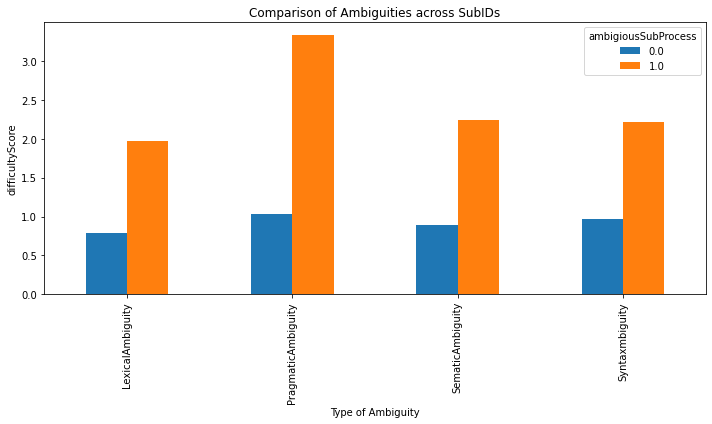

In [32]:
### PERCEIVED DIFFICULTY
measure = 'difficultyScore'

#Compute descriptives
means = compute_descriptives_mean(perceivedDifficultyData, 'questionEventType', 'questionOffset',  ['ambigiousSubProcess','Type1'], ['participant', 'MainQuestionID'], measure)
# Pivot the table
pivot_df = means.pivot_table(index='Type1', columns='ambigiousSubProcess', values=measure)
# Display the pivoted data
display(pivot_df)


# Compute inferentials
conditions = [(0,1)]
for type1 in ['LexicalAmbiguity','PragmaticAmbiguity','SematicAmbiguity','Syntaxmbiguity']:
    print(type1)
    res = compute_inferentials(perceivedDifficultyData, ['participant', 'ambigiousSubProcess','MainQuestionID','Type1'], measure, 'ambigiousSubProcess', conditions, additional_filters=
                            {'Type1': type1})
    
# Plot
fig, ax = plt.subplots(figsize=(10, 6))
pivot_df.plot(kind='bar', ax=ax)
plt.title('Comparison of Ambiguities across SubIDs')
plt.ylabel(measure)
plt.xlabel('Type of Ambiguity')
plt.tight_layout()
plt.show()

ambigiousSubProcess,0.0,1.0
Type1,,
LexicalAmbiguity,21.610,21.463
PragmaticAmbiguity,32.754,74.508
SematicAmbiguity,28.354,41.547
Syntaxmbiguity,25.212,34.308


LexicalAmbiguity
0 1
WilcoxonResult(statistic=144.5, pvalue=0.6338268518447876)
PragmaticAmbiguity
0 1
WilcoxonResult(statistic=0.0, pvalue=1.1368683772161603e-13)
SematicAmbiguity
0 1
WilcoxonResult(statistic=33.5, pvalue=2.3377651814371347e-08)
Syntaxmbiguity
0 1
WilcoxonResult(statistic=59.5, pvalue=1.0302073860657401e-08)


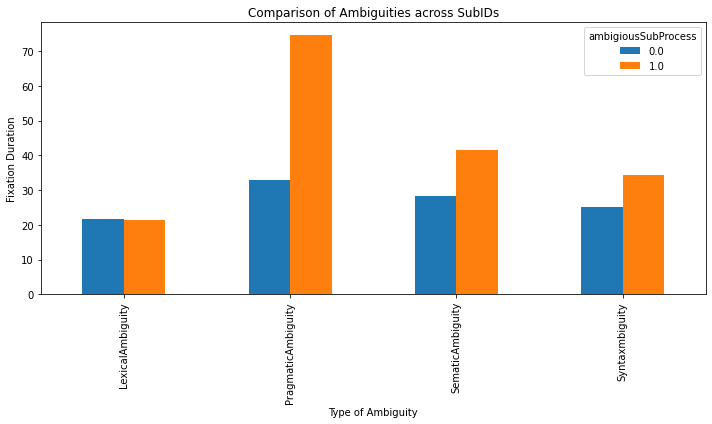

In [33]:
### MEAN NUMBER OF FIXATIONS ABOVE 250 MS
measure = 'Fixation Duration'
measure_out = 'MentalDemandFixations'

#select fixation data and drop na
fixationData = eifaData.loc[(~eifaData['FixID'].isna()) & (~eifaData['currentQuestion'].isna())].copy(deep=True)

#set fixation threshold
fixationData = fixationData[fixationData['Fixation Duration']>250]

#Descriptives
means =compute_descriptives_meanFixationCount(fixationData, 'Type2', 'MainQuestion', ['ambigiousSubProcess','Type1'], ['participant', 'currentQuestion','SubID'], measure, measure_out)
# Pivot the table
pivot_df = means.pivot_table(index='Type1', columns='ambigiousSubProcess', values=measure_out)
# Display the pivoted data
display(pivot_df)

#Inferentials
conditions = [(0,1)]                   
for type1 in ['LexicalAmbiguity','PragmaticAmbiguity','SematicAmbiguity','Syntaxmbiguity']:
    print(type1)
    res = compute_inferentials_meanFixationCount(fixationData, ['participant', 'ambigiousSubProcess', 'currentQuestion', 'SubID'], measure, 'ambigiousSubProcess', conditions, additional_filters=
                                {'Type2': 'MainQuestion',
                                 'Type1': type1,
                                })
    
# Plot
fig, ax = plt.subplots(figsize=(10, 6))
pivot_df.plot(kind='bar', ax=ax)
plt.title('Comparison of Ambiguities across SubIDs')
plt.ylabel(measure)
plt.xlabel('Type of Ambiguity')
plt.tight_layout()
plt.show()

ambigiousSubProcess,0.0,1.0
Type1,,
LexicalAmbiguity,16258.680,19436.565
PragmaticAmbiguity,27198.497,51667.651
SematicAmbiguity,25809.034,39514.319
Syntaxmbiguity,26414.001,32977.135


LexicalAmbiguity
0 1
WilcoxonResult(statistic=84.0, pvalue=0.018977344036102295)
PragmaticAmbiguity
0 1
WilcoxonResult(statistic=6.0, pvalue=1.5916157281026244e-12)
SematicAmbiguity
0 1
WilcoxonResult(statistic=12.0, pvalue=5.093170329928398e-10)
Syntaxmbiguity
0 1
WilcoxonResult(statistic=183.0, pvalue=0.00015205688123387517)


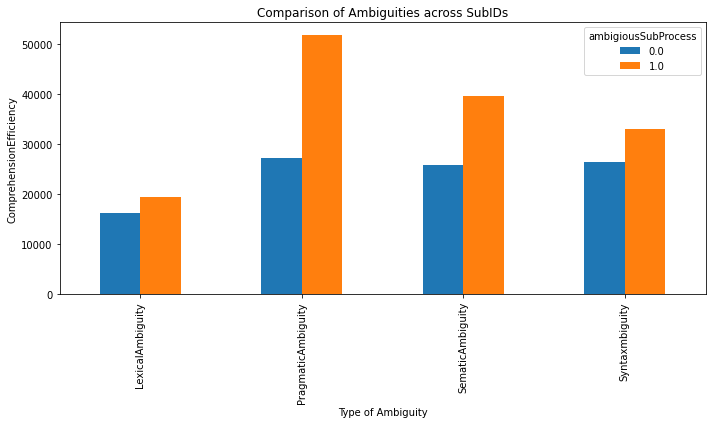

In [34]:
### Comprehension Efficiency
measure = 'ComprehensionEfficiency'

# Keep only MainQuestions
f_eifaData = eifaData[eifaData['Type2'] == 'MainQuestion'].copy(deep=True)

# Group consecutive TabNames
f_eifaData_gr = f_eifaData.groupby([(f_eifaData['tabName'].shift() != f_eifaData['tabName']).cumsum(),'participant','currentQuestion','SubID','Type1','Type2','Type3','ambigiousSubProcess'], as_index=False)

# Perform aggregations on grouping:
agg_f_eifaData = f_eifaData_gr.agg(
     ComprehensionEfficiency=('Timestamp', (lambda x: x.iloc[-1]-x.iloc[0])),
     
)

# Flatten
agg_f_eifaData = agg_f_eifaData.reset_index()

# Descriptives
means = compute_descriptives_mean(agg_f_eifaData, 'Type2', 'MainQuestion',  ['ambigiousSubProcess', 'Type1'], ['participant', 'currentQuestion'], measure)
# Pivot the table
pivot_df = means.pivot_table(index='Type1', columns='ambigiousSubProcess', values=measure)
# Display the pivoted data
display(pivot_df)

# Inferentials
conditions = [(0,1)]
for type1 in ['LexicalAmbiguity','PragmaticAmbiguity','SematicAmbiguity','Syntaxmbiguity']:
    print(type1)
    res = compute_inferentials(agg_f_eifaData, ['participant', 'ambigiousSubProcess', 'currentQuestion','Type1'], measure, 'ambigiousSubProcess', conditions, additional_filters=
                                {'Type2': 'MainQuestion',
                                 'Type1': type1})

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
pivot_df.plot(kind='bar', ax=ax)
plt.title('Comparison of Ambiguities across SubIDs')
plt.ylabel(measure)
plt.xlabel('Type of Ambiguity')
plt.tight_layout()
plt.show()    

ambigiousSubProcess,0.0,1.0
Type1,,
LexicalAmbiguity,18.086,22.610
PragmaticAmbiguity,21.159,46.357
SematicAmbiguity,20.067,34.573
Syntaxmbiguity,19.151,27.489


LexicalAmbiguity
0 1
WilcoxonResult(statistic=66.5, pvalue=0.00806879997253418)
PragmaticAmbiguity
0 1
WilcoxonResult(statistic=3.0, pvalue=5.684341886080801e-13)
SematicAmbiguity
0 1
WilcoxonResult(statistic=20.5, pvalue=2.699380274862051e-09)
Syntaxmbiguity
0 1
WilcoxonResult(statistic=70.0, pvalue=1.1335346562642562e-06)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


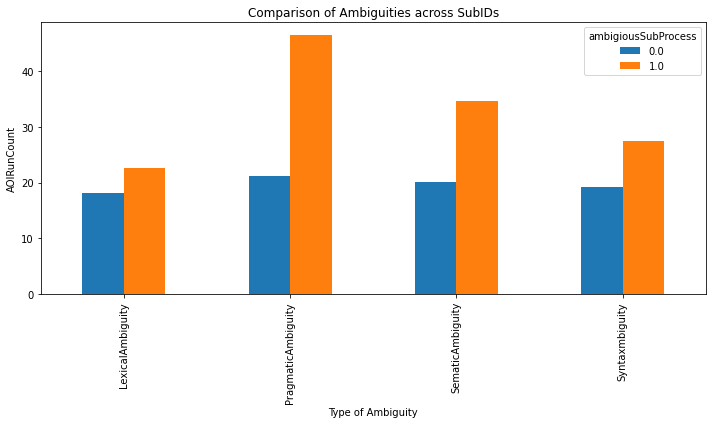

/Users/amineabbad-andaloussi/Library/Python/3.9/lib/python/site-packages/pandas/core/frame.py:9190: FutureWarning: Passing 'suffixes' which cause duplicate columns {'file_x', 'Ambigious_x', 'element_type_x', 'name_x', 'elementID_x', 'Location relative to ambiguity_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


In [35]:
# AOI Run count
measure = 'AOIRunCount'

#detect dwells

# Keep only MainQuestions
f_eifaData = eifaData[eifaData['Type2'] == 'MainQuestion'].copy(deep=True)

#Keep only fixations
f_eifaData = f_eifaData.loc[(~f_eifaData['FixID'].isna()) & (~f_eifaData['currentQuestion'].isna())].copy(deep=True)

# Group by consecutive element and aggr by fixation Count -> obtained dwells
f_eifaData["elementCopy"] = f_eifaData["element"]
f_eifaData_gr = f_eifaData.groupby([(f_eifaData['elementCopy'].shift() != f_eifaData['elementCopy']).cumsum(),'element','tabName','participant','currentQuestion','SubID','Type1','Type2','Type3','ambigiousSubProcess'], as_index=False).agg(
    FixationCountPerDwell=('FixID', 'count'))

f_eifaData_gr = f_eifaData_gr.reset_index(drop=True)

#add extra element attributes to f_eifaData_gr
f_eifaData_gr = f_eifaData_gr.merge(ambiguityElementsDetails, left_on=['element','SubID','tabName'], right_on=['elementID','SubID','file'], how='left')

# Fill any remaining NaN values in 'elementLabel' with a placeholder (e.g., 'NA')
f_eifaData_gr['element'].fillna(' ', inplace=True)

# Find rows in df where 'elementLabel' ends with '_label'
label_rows = f_eifaData_gr[f_eifaData_gr['element'].str.endswith('_label')].copy()

# For each of these rows, fetch and update the columns from ambiguityElementsDetails
for idx, row in label_rows.iterrows():
    original_element_label = row['element'].replace('_label', '')
    
    # Find the row in ambiguityElementsDetails with the original_element_label i.e., id in ambiguityElementsDetails
    original_row = ambiguityElementsDetails[(ambiguityElementsDetails['elementID'] == original_element_label) & (ambiguityElementsDetails['file'] == row['tabName'])].iloc[0]
    
    # Update the columns for the current 'label_row' from the found row in ambiguityElementsDetails
    label_rows.loc[idx, 'element_type'] = original_row['element_type']
    label_rows.loc[idx, 'elementID'] = original_row['elementID']
    label_rows.loc[idx, 'name'] = original_row['name']
    label_rows.loc[idx, 'file'] = original_row['file']
    label_rows.loc[idx, 'Ambigious'] = original_row['Ambigious']
    label_rows.loc[idx, 'Location relative to ambiguity'] = original_row['Location relative to ambiguity']
    
# Update the original dataframe (df) with the modified rows
f_eifaData_gr.update(label_rows)

#identify transitions
transitions = pd.DataFrame()
transitions[['participant','currentQuestion','Type1','tabName','ambigiousSubProcess','SubID','TransitionSource', 'TransitionSource_element_type','TransitionTarget','TransitionTarget_element_type']] = f_eifaData_gr.apply(lambda x: identifyTransition(f_eifaData_gr,x.name), axis=1)

#keep only transitions from AOI to AOI
transitions = transitions[(~transitions['TransitionSource_element_type'].isna()) & (~transitions['TransitionTarget_element_type'].isna()) &  (transitions['TransitionSource_element_type']!="process") & (transitions['TransitionTarget_element_type']!="process")]
transitions = transitions.reset_index(drop=True)

#add measure attribute
transitions[measure] = 1

# Descriptives
means = compute_descriptives_AOIRunCount(transitions, ['ambigiousSubProcess','Type1'], ['participant', 'currentQuestion','SubID'], measure)

# Pivot the table
pivot_df = means.pivot_table(index='Type1', columns='ambigiousSubProcess', values=measure)
# Display the pivoted data
display(pivot_df)

# Inferntials
conditions = [(0,1)]                   
for type1 in ['LexicalAmbiguity','PragmaticAmbiguity','SematicAmbiguity','Syntaxmbiguity']:
    print(type1)
    res = compute_inferentials_AOIRunCount(transitions, ['participant', 'ambigiousSubProcess','currentQuestion', 'SubID'], measure, 'ambigiousSubProcess', conditions, additional_filters=
                                {
                                 'Type1': type1,
                                })
    
    
# Plot
fig, ax = plt.subplots(figsize=(10, 6))
pivot_df.plot(kind='bar', ax=ax)
plt.title('Comparison of Ambiguities across SubIDs')
plt.ylabel(measure)
plt.xlabel('Type of Ambiguity')
plt.tight_layout()
plt.show()    #add extra element attributes to f_eifaData_gr
f_eifaData_gr = f_eifaData_gr.merge(ambiguityElementsDetails, left_on=['element','SubID','tabName'], right_on=['elementID','SubID','file'], how='left')#add extra element attributes to f_eifaData_gr
f_eifaData_gr = f_eifaData_gr.merge(ambiguityElementsDetails, left_on=['element','SubID','tabName'], right_on=['elementID','SubID','file'], how='left')#add extra element attributes to f_eifaData_gr
f_eifaData_gr = f_eifaData_gr.merge(ambiguityElementsDetails, left_on=['element','SubID','tabName'], right_on=['elementID','SubID','file'], how='left')#add extra element attributes to f_eifaData_gr
f_eifaData_gr = f_eifaData_gr.merge(ambiguityElementsDetails, left_on=['element','SubID','tabName'], right_on=['elementID','SubID','file'], how='left')

Example of a non-ambiguous sub-process (task:task10sem, participant:SP7-withinTab)


<ipython-input-14-c4750443c769>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["timestamp_formatted"] = pd.to_datetime(subset['Timestamp'], unit='ms')
<ipython-input-14-c4750443c769>:15: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  subset = pm4py.format_dataframe(subset, case_id='caiseID', activity_key='name', timestamp_key='timestamp_formatted')
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pm4py/utils.py:495: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future relea

exporting log, completed traces ::   0%|          | 0/1 [00:00<?, ?it/s]

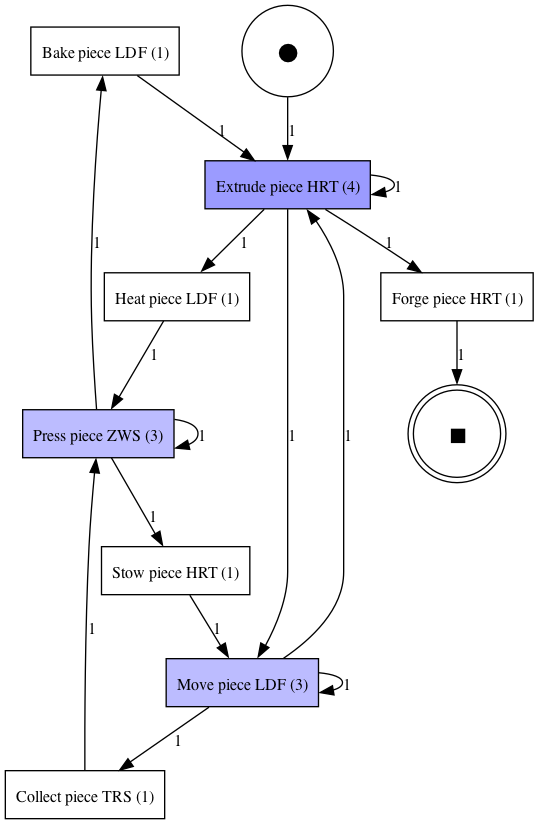

Example of an ambiguous sub-process (task:{task_eg}, participant:{participant_eg})


<ipython-input-14-c4750443c769>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["timestamp_formatted"] = pd.to_datetime(subset['Timestamp'], unit='ms')
<ipython-input-14-c4750443c769>:15: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  subset = pm4py.format_dataframe(subset, case_id='caiseID', activity_key='name', timestamp_key='timestamp_formatted')
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pm4py/utils.py:495: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future relea

exporting log, completed traces ::   0%|          | 0/1 [00:00<?, ?it/s]

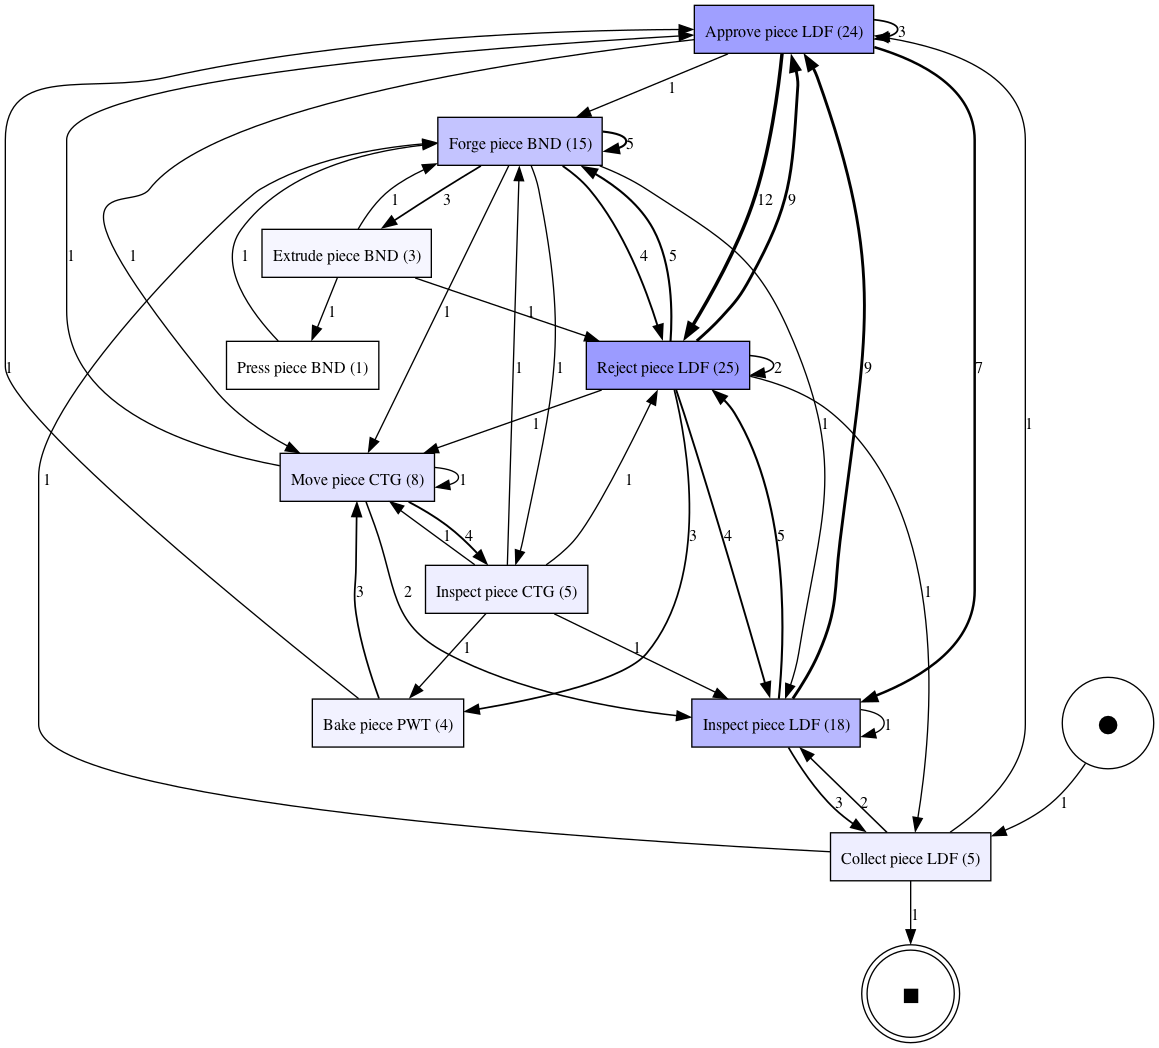

In [36]:
#Process Maps

# Keep only MainQuestions
f_eifaData = eifaData[eifaData['Type2'] == 'MainQuestion'].copy(deep=True)

#Keep only fixations
f_eifaData = f_eifaData.loc[(~f_eifaData['FixID'].isna()) & (~f_eifaData['currentQuestion'].isna())].copy(deep=True)

# Group by consecutive element and aggr by fixation Count -> obtain dwells
f_eifaData["elementCopy"] = f_eifaData["element"]
f_eifaData_gr = f_eifaData.groupby([(f_eifaData['elementCopy'].shift() != f_eifaData['elementCopy']).cumsum(),'element','tabName','participant','currentQuestion','SubID','Type1','Type2','Type3','Type4'], as_index=False).agg(
    Timestamp=('Timestamp', (lambda x: x.iloc[0])),
    VisitStart=('Timestamp', (lambda x: x.iloc[0])),
    VisitEnd=('Timestamp', (lambda x: x.iloc[-1])),
    VisitDuration=('Timestamp', (lambda x: (x.iloc[-1]-x.iloc[0]) + f_eifaData.loc[x.index[-1], 'Fixation Duration'])),
    FixationCountPerDwell=('FixID', 'count'),
)

#Compute model context relatative to sub2
ambiguityElementsDetails['Model position relative to ambiguity'] = ambiguityElementsDetails['SubID'].apply(get_context)


#add extra element attributes to f_eifaData_gr
f_eifaData_gr = f_eifaData_gr.merge(ambiguityElementsDetails, left_on=['element','SubID','tabName'], right_on=['elementID','SubID','file'], how='left')

# If there's no label available for a given element, use the element value itself
f_eifaData_gr['name'].fillna(f_eifaData_gr['elementID'], inplace=True)

#define question ID
f_eifaData_gr["caiseID"] = f_eifaData_gr["participant"] + f_eifaData_gr["currentQuestion"].astype('str')

#Examples reported in the paper
task_eg = "task10sem"
participant_eg = "SP7-withinTab"

print(f"Example of a non-ambiguous sub-process (task:{task_eg}, participant:{participant_eg})")
dfg(f_eifaData_gr,task_eg,"sub1",participant_eg,1)

print("Example of an ambiguous sub-process (task:{task_eg}, participant:{participant_eg})")
dfg(f_eifaData_gr,task_eg,"sub2",participant_eg,1)

In [ ]:
#Generate all process maps
#Iterate over all participants
for participant in f_eifaData_gr['participant'].unique():
    #Interate over all tasks
    for task in f_eifaData_gr['Type4'].unique():
        #Generate and Save process maps for non-ambigious (sub1) and ambigious (sub2)sub-processes
        dfg(f_eifaData_gr,task,"sub1",participant)
        dfg(f_eifaData_gr,task,"sub2",participant)